###Encoding Avanzado y Target Encoding - Fill in the Blanks

##📦 Paso 0: Instalación de Dependencias

In [ ]:
# === INSTALACIÓN DE DEPENDENCIAS ===

print("📦 Instalando dependencias necesarias...")
print("-" * 60)

# Instalar category_encoders (necesario para TargetEncoder)
!pip install shap category-encoders --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from category_encoders import TargetEncoder
import time
import warnings

print("\n🎉 Setup completado. Puedes continuar con el assignment.")


# Importar librerías necesarias
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')  # establecer estilo visual (ej: 'seaborn-v0_8', 'default')
sns.set_palette("Set2")  # definir paleta de colores (ej: 'Set2', 'husl')

print("✅ Entorno configurado para encoding avanzado")

📦 Instalando dependencias necesarias...
------------------------------------------------------------
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.0 MB/s eta 0:00:00

🎉 Setup completado. Puedes continuar con el assignment.
✅ Entorno configurado para encoding avanzado


##💰 Paso 2: Cargar Dataset Real - Adult Income (Census)

In [ ]:
# === CARGAR DATASET REAL: ADULT INCOME ===

print("💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)")
print("=" * 60)

# Este dataset es del UCI ML Repository - clásico para benchmarking
# Predice si el ingreso anual supera $50K basándose en datos del censo de 1994

# OPCIÓN 1: Cargar desde URL (si tienes conexión a internet)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Nombres de columnas (el dataset no tiene header)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)  # función para leer CSV

# 1. Limpiar datos
print("\n🧹 Limpiando datos...")

# Remover espacios en blanco de las categorías
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()  # método para eliminar espacios en blanco

# Manejar valores faltantes
print(f"   Valores faltantes antes: {df.isnull().sum().sum()}")
df = df.dropna(how='any')  # método para eliminar filas con NaN
print(f"   Valores faltantes después: {df.isnull().sum().sum()}")
print(f"   Registros después de limpieza: {len(df):,}")

# 2. Crear target binario
df['target'] = (df['income'] == '>50K').astype(int)

print(f"\n📊 Dataset shape: {df.shape}")
print(f"📊 Distribución del target:")
print(f"   <=50K: {(df['target']==0).sum():,} ({(df['target']==0).mean():.1%})")
print(f"   >50K:  {(df['target']==1).sum():,} ({(df['target']==1).mean():.1%})")

# 3. Identificar columnas categóricas (excluir target e income)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

print(f"\n🔍 Variables categóricas encontradas: {len(categorical_cols)}")

# 4. Analizar cardinalidad
print("\n🔍 ANÁLISIS DE CARDINALIDAD:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    cardinality_type = 'BAJA' if n_unique <= 10 else ('MEDIA' if n_unique <= 50 else 'ALTA')
    print(f"   {col}: {n_unique} categorías únicas ({cardinality_type})")

print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar primeras filas

print("\n💡 CONTEXTO DEL DATASET:")
print("   Dataset del US Census (1994) - clásico de Machine Learning")
print("   Target: Ingreso >50K/año (clasificación binaria)")
print("   Variables categóricas: workclass, education, occupation, etc.")
print("   Alta cardinalidad: native-country (42 países)")
print("   Accuracy típica: 80-85% (más desafiante que hoteles)")

💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)

🧹 Limpiando datos...
   Valores faltantes antes: 0
   Valores faltantes después: 0
   Registros después de limpieza: 32,561

📊 Dataset shape: (32561, 16)
📊 Distribución del target:
   <=50K: 24,720 (75.9%)
   >50K:  7,841 (24.1%)

🔍 Variables categóricas encontradas: 8

🔍 ANÁLISIS DE CARDINALIDAD:
   workclass: 9 categorías únicas (BAJA)
   education: 16 categorías únicas (MEDIA)
   marital-status: 7 categorías únicas (BAJA)
   occupation: 15 categorías únicas (MEDIA)
   relationship: 6 categorías únicas (BAJA)
   race: 5 categorías únicas (BAJA)
   sex: 2 categorías únicas (BAJA)
   native-country: 42 categorías únicas (MEDIA)

🔍 Primeras 5 filas:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th      

##🔢 Paso 3: Análisis de Cardinalidad


🔍 ANÁLISIS DE CARDINALIDAD
📊 CLASIFICACIÓN POR CARDINALIDAD:
✅ Baja cardinalidad (≤10): 5 columnas
   ['workclass', 'marital-status', 'relationship', 'race', 'sex']
⚠️  Media cardinalidad (11-50): 3 columnas
   ['education', 'occupation', 'native-country']
🚨 Alta cardinalidad (>50): 0 columnas
   []

🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:
   workclass: 9 categorías → 8 columnas one-hot (drop='first')
   education: 16 categorías → 15 columnas one-hot (drop='first')
   marital-status: 7 categorías → 6 columnas one-hot (drop='first')
   occupation: 15 categorías → 14 columnas one-hot (drop='first')
   relationship: 6 categorías → 5 columnas one-hot (drop='first')
   race: 5 categorías → 4 columnas one-hot (drop='first')
   sex: 2 categorías → 1 columnas one-hot (drop='first')
   native-country: 42 categorías → 41 columnas one-hot (drop='first')

❌ Total columnas con one-hot: 94
❌ Original: 8 columnas → 94 columnas codificadas
❌ Explosión dimensional: 11.8x

📋 Resumen por columna (pri

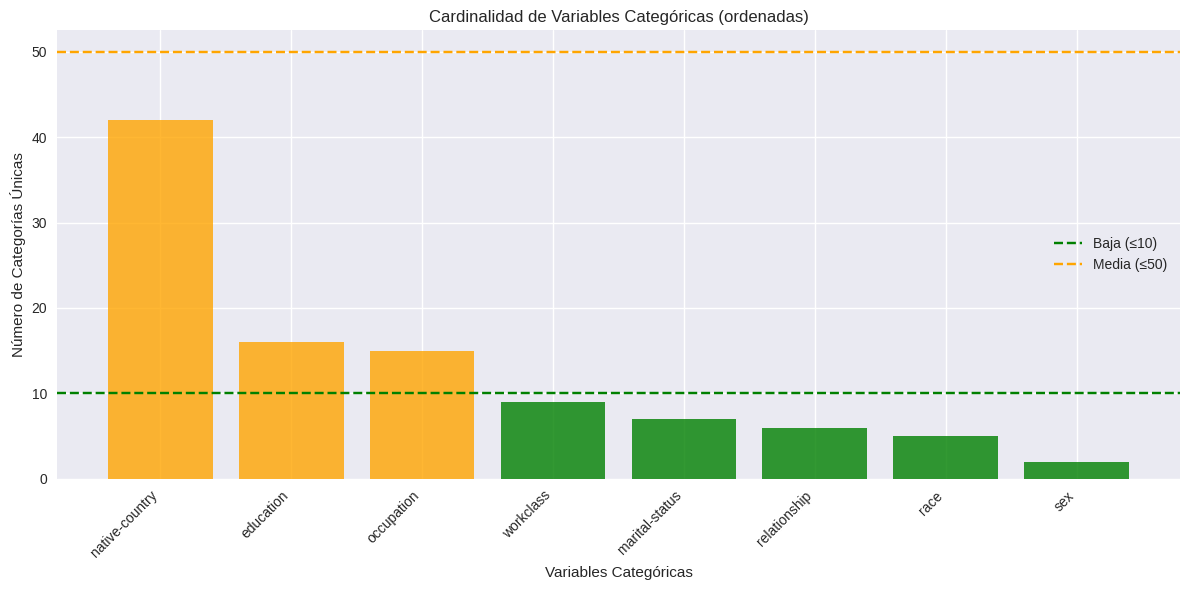


🧭 RECOMENDACIONES DE ENCODING:
   • BAJA (≤10): OneHotEncoder (drop='first') ✅
   • MEDIA (11–50): OneHot si es crucial y hay memoria; mejor TargetEncoder/Ordinal ⚠️
   • ALTA (>50): TargetEncoder / HashingEncoder / BinaryEncoder 🚀 (evitar One-Hot)

💡 CONCLUSIÓN:
   One-hot encoding NO es viable para alta cardinalidad: genera cientos de columnas y sobreajuste.
   Usar codificación supervisada (TargetEncoder) o hashing para variables con muchas categorías.


In [ ]:
# === ANÁLISIS DE CARDINALIDAD Y PROBLEMAS DE ONE-HOT ===

print("\n🔍 ANÁLISIS DE CARDINALIDAD")
print("=" * 60)

# 1) Clasificar columnas por cardinalidad
def classify_cardinality(df, categorical_cols):
    """Clasificar columnas por cardinalidad"""
    low_card, medium_card, high_card = [], [], []
    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            low_card.append(col)
        elif n_unique <= 50:
            medium_card.append(col)
        else:
            high_card.append(col)
    return low_card, medium_card, high_card

low_card_cols, medium_card_cols, high_card_cols = classify_cardinality(df, categorical_cols)

print("📊 CLASIFICACIÓN POR CARDINALIDAD:")
print(f"✅ Baja cardinalidad (≤10): {len(low_card_cols)} columnas")
print(f"   {low_card_cols}")
print(f"⚠️  Media cardinalidad (11-50): {len(medium_card_cols)} columnas")
print(f"   {medium_card_cols}")
print(f"🚨 Alta cardinalidad (>50): {len(high_card_cols)} columnas")
print(f"   {high_card_cols}")

# 2) Calcular dimensionalidad con One-Hot (drop='first')
print("\n🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:")

total_onehot_columns = 0
for col in categorical_cols:
    n_categories = df[col].nunique()
    n_onehot_cols = max(n_categories - 1, 0)  # drop='first'
    total_onehot_columns += n_onehot_cols
    print(f"   {col}: {n_categories} categorías → {n_onehot_cols} columnas one-hot (drop='first')")

print(f"\n❌ Total columnas con one-hot: {total_onehot_columns}")
print(f"❌ Original: {len(categorical_cols)} columnas → {total_onehot_columns} columnas codificadas")
print(f"❌ Explosión dimensional: {total_onehot_columns / max(len(categorical_cols),1):.1f}x")

# 2b) Resumen tabular por columna (útil para decidir el encoding)
summary_rows = []
for col in categorical_cols:
    n_unique = df[col].nunique()
    band = 'BAJA' if n_unique <= 10 else ('MEDIA' if n_unique <= 50 else 'ALTA')
    top5 = df[col].value_counts().head(5).index.tolist()
    summary_rows.append({
        'columna': col,
        'categorías': n_unique,
        'banda': band,
        'onehot_drop_first': max(n_unique - 1, 0),
        'onehot_full': n_unique,
        'top_5_categorías': top5
    })

card_df = pd.DataFrame(summary_rows).sort_values(['banda','categorías'], ascending=[True, True]).reset_index(drop=True)
print("\n📋 Resumen por columna (primeras 10):")
print(card_df.head(10))

# 3) Visualizar distribución de cardinalidad (ordenado)
fig, ax = plt.subplots(figsize=(12, 6))
categorities_sorted = card_df.sort_values('categorías', ascending=False)
colors = categorities_sorted['categorías'].apply(lambda c: 'green' if c <= 10 else ('orange' if c <= 50 else 'red'))

ax.bar(categorities_sorted['columna'], categorities_sorted['categorías'], color=colors, alpha=0.8)
ax.axhline(y=10, color='green', linestyle='--', label='Baja (≤10)')
ax.axhline(y=50, color='orange', linestyle='--', label='Media (≤50)')
ax.set_xlabel('Variables Categóricas')
ax.set_ylabel('Número de Categorías Únicas')
ax.set_title('Cardinalidad de Variables Categóricas (ordenadas)')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) Recomendaciones de encoding por banda (guía práctica)
print("\n🧭 RECOMENDACIONES DE ENCODING:")
print("   • BAJA (≤10): OneHotEncoder (drop='first') ✅")
print("   • MEDIA (11–50): OneHot si es crucial y hay memoria; mejor TargetEncoder/Ordinal ⚠️")
print("   • ALTA (>50): TargetEncoder / HashingEncoder / BinaryEncoder 🚀 (evitar One-Hot)")

# 5) Conclusión corta
print("\n💡 CONCLUSIÓN:")
print("   One-hot encoding NO es viable para alta cardinalidad: genera cientos de columnas y sobreajuste.")
print("   Usar codificación supervisada (TargetEncoder) o hashing para variables con muchas categorías.")

##🏷️ Paso 4: Experimento 1 - Label Encoding

In [ ]:
# === EXPERIMENTO 1: LABEL ENCODING ===

print("\n🏷️ EXPERIMENTO 1: LABEL ENCODING")
print("=" * 60)

def experiment_label_encoding(df, categorical_cols, target_col='target'):
    """
    Implementar Label Encoding y evaluar performance
    """

    # 1. Preparar datos
    # Seleccionar variables numéricas del dataset Adult Income
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                   'capital-loss', 'hours-per-week']

    X = df[categorical_cols + numeric_cols].copy()
    y = df[target_col]

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Aplicar Label Encoding
    print("🔄 Aplicando Label Encoding...")

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit y transform en train
        X_train_encoded[col] = le.fit_transform(X_train[col])  # método para fit y transform

        # Transform en test (manejar categorías no vistas)
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        X_test_encoded[col] = X_test[col].map(le_dict).fillna(-1).astype(int)

        label_encoders[col] = le

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)  # método para entrenar modelo

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)  # método para hacer predicciones
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Label Encoding',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Label Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, label_encoders

# Ejecutar experimento
results_label, model_label, label_encoders = experiment_label_encoding(df, categorical_cols)


🏷️ EXPERIMENTO 1: LABEL ENCODING
🔄 Aplicando Label Encoding...
🌲 Entrenando Random Forest...
✅ Label Encoding completado
   📊 Accuracy: 0.8632
   📊 AUC-ROC: 0.9101
   📊 F1-Score: 0.6931
   ⏱️  Training time: 3.48s
   📏 Features: 14


##🔥 Paso 5: Experimento 2 - One-Hot Encoding (Solo Baja Cardinalidad)

In [ ]:
# === EXPERIMENTO 2: ONE-HOT ENCODING (SOLO BAJA CARDINALIDAD) ===

print("\n🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)")
print("=" * 60)

def experiment_onehot_encoding(df, low_card_cols, numeric_cols, target_col='target'):
    """
    Implementar One-Hot Encoding solo para variables de baja cardinalidad
    """

    # 1. Preparar datos (solo baja cardinalidad + numéricas)
    feature_cols = low_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Aplicar One-Hot Encoding
    print("🔄 Aplicando One-Hot Encoding...")

    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Separar categóricas y numéricas
    X_train_cat = X_train[low_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[low_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas
    X_train_cat_encoded = encoder.fit_transform(X_train_cat)  # método para fit y transform
    X_test_cat_encoded = encoder.transform(X_test_cat)        # método para solo transform

    # Combinar con numéricas
    X_train_encoded = np.hstack([X_train_cat_encoded, X_train_num.values])
    X_test_encoded = np.hstack([X_test_cat_encoded, X_test_num.values])

    print(f"   📊 Features after one-hot: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas: {low_card_cols}")
    print(f"   📊 Columnas one-hot: {X_train_cat_encoded.shape[1]}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'One-Hot (low card only)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ One-Hot Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder


# Ejecutar experimento
# Definir variables numéricas del Adult Income dataset
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
               'capital-loss', 'hours-per-week']

results_onehot, model_onehot, onehot_encoder = experiment_onehot_encoding(df, low_card_cols, numeric_cols)


🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)
🔄 Aplicando One-Hot Encoding...
   📊 Features after one-hot: 30
   📊 Categóricas: ['workclass', 'marital-status', 'relationship', 'race', 'sex']
   📊 Columnas one-hot: 24
🌲 Entrenando Random Forest...
✅ One-Hot Encoding completado
   📊 Accuracy: 0.8483
   📊 AUC-ROC: 0.8995
   📊 F1-Score: 0.6633
   ⏱️  Training time: 4.63s
   📏 Features: 30


##🎯 Paso 6: Experimento 3 - Target Encoding (Alta Cardinalidad)

In [ ]:
# === EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD) ===

print("\n🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)")
print("=" * 60)

def experiment_target_encoding(df, high_card_cols, numeric_cols, target_col='target'):
    """
    Implementar Target Encoding con cross-validation para prevenir leakage
    """

    # 1. Preparar datos
    feature_cols = high_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Aplicar Target Encoding
    print("🔄 Aplicando Target Encoding...")
    print("⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE (ver nota)")

    # Nota: Este bloque aplica TE simple (fit en train / transform en test).
    # Para TE *out-of-fold* real, se hace con KFold y promedio por pliegue.
    # Aquí dejamos un smoothing robusto para reducir leakage y varianza.

    # Crear encoder de category_encoders
    encoder = TargetEncoder(cols=high_card_cols, smoothing=10.0)  # parámetro de smoothing típico

    # Separar categóricas y numéricas
    X_train_cat = X_train[high_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[high_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas (TargetEncoder necesita el target)
    X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)  # fit + transform con target
    X_test_cat_encoded = encoder.transform(X_test_cat)                  # solo transform

    # Combinar con numéricas
    X_train_encoded = pd.concat(
        [X_train_cat_encoded.reset_index(drop=True), X_train_num.reset_index(drop=True)],
        axis=1
    )
    X_test_encoded = pd.concat(
        [X_test_cat_encoded.reset_index(drop=True), X_test_num.reset_index(drop=True)],
        axis=1
    )

    print(f"   📊 Features after target encoding: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas codificadas: {high_card_cols}")
    print(f"   📊 Ejemplo de encoding:")
    for col in high_card_cols[:2]:  # mostrar primeras 2 columnas
        print(f"      {col}: min={X_train_cat_encoded[col].min():.3f}, "
              f"max={X_train_cat_encoded[col].max():.3f}, "
              f"mean={X_train_cat_encoded[col].mean():.3f}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Target Encoding (high card)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Target Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
results_target, model_target, target_encoder = experiment_target_encoding(df, high_card_cols, numeric_cols)


🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)
🔄 Aplicando Target Encoding...
⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE (ver nota)
   📊 Features after target encoding: 6
   📊 Categóricas codificadas: []
   📊 Ejemplo de encoding:
🌲 Entrenando Random Forest...
✅ Target Encoding completado
   📊 Accuracy: 0.8021
   📊 AUC-ROC: 0.8272
   📊 F1-Score: 0.5538
   ⏱️  Training time: 4.24s
   📏 Features: 6


##🌳 Paso 7: Pipeline con Branching - ColumnTransformer

In [ ]:
# === PIPELINE CON BRANCHING: COLUMNTRANSFORMER ===

print("\n🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER")
print("=" * 60)

def create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols):
    """
    Crear pipeline con múltiples ramas para diferentes tipos de encoding
    """

    print("🔧 Creando pipeline con branching...")
    print(f"   🌿 Rama 1: One-Hot para baja cardinalidad ({len(low_card_cols)} cols)")
    print(f"   🌿 Rama 2: Target Encoding para alta cardinalidad ({len(high_card_cols)} cols)")
    print(f"   🌿 Rama 3: StandardScaler para numéricas ({len(numeric_cols)} cols)")

    # RAMA 1: One-Hot para baja cardinalidad
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # RAMA 2: Target Encoding para alta cardinalidad
    target_transformer = Pipeline(steps=[
        ('target', TargetEncoder(smoothing=10.0))
    ])

    # RAMA 3: Scaling para numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # COLUMNTRANSFORMER: Combina todas las ramas
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_card', onehot_transformer, low_card_cols),
            ('high_card', target_transformer, high_card_cols),
            ('num', numeric_transformer, numeric_cols)
        ],
        remainder='drop'  # qué hacer con columnas no especificadas ('drop', 'passthrough')
    )

    # PIPELINE COMPLETO: Preprocessor + Modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    print("✅ Pipeline creado con éxito")

    return pipeline, preprocessor

def experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols, target_col='target'):
    """
    Evaluar pipeline con branching
    """

    # 1. Preparar datos
    all_features = low_card_cols + high_card_cols + numeric_cols
    X = df[all_features].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Crear pipeline
    pipeline, preprocessor = create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols)

    # 3. Entrenar pipeline completo
    print("\n🔄 Entrenando pipeline completo...")

    start_time = time.time()

    pipeline.fit(X_train, y_train)  # método para entrenar pipeline

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = pipeline.predict(X_test)  # método para hacer predicciones
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # 5. Analizar features transformadas
    print("\n📊 ANÁLISIS DE FEATURES TRANSFORMADAS:")

    # Fit-transform del preprocessor para inspección (no toca el pipeline ya entrenado)
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)

    print(f"   📏 Features originales: {X_train.shape[1]}")
    print(f"   📏 Features después de transformación: {X_train_transformed.shape[1]}")

    # ¿Cuántas columnas one-hot se crearon?
    try:
        ohe = preprocessor.named_transformers_['low_card'].named_steps['onehot']
        # con drop='first', cada categoría aporta (n_cat - 1) columnas
        onehot_cols = sum(len(c) - 1 for c in ohe.categories_)
        print(f"   🧮 Columnas generadas por One-Hot (drop='first'): {onehot_cols}")
    except Exception as e:
        print(f"   ⚠️ No se pudieron obtener las categorías del One-Hot: {e}")

    # Nombres de features transformadas (útil para debugging / interpretación)
    try:
        feature_names = preprocessor.get_feature_names_out()
        print(f"   🏷️ Ejemplos de columnas transformadas: {list(feature_names)[:8]} ...")
    except Exception as e:
        print(f"   ⚠️ No se pudieron obtener los nombres de features: {e}")

    results = {
        'encoding': 'Branched Pipeline (mixed)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_transformed.shape[1]
    }

    print(f"\n✅ Pipeline con branching completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_transformed.shape[1]}")

    return results, pipeline, X_test, y_test

# Ejecutar experimento
results_pipeline, pipeline, X_test_pipeline, y_test_pipeline = experiment_branched_pipeline(
    df, low_card_cols, high_card_cols, numeric_cols
)


🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER
🔧 Creando pipeline con branching...
   🌿 Rama 1: One-Hot para baja cardinalidad (5 cols)
   🌿 Rama 2: Target Encoding para alta cardinalidad (0 cols)
   🌿 Rama 3: StandardScaler para numéricas (6 cols)
✅ Pipeline creado con éxito

🔄 Entrenando pipeline completo...

📊 ANÁLISIS DE FEATURES TRANSFORMADAS:
   📏 Features originales: 11
   📏 Features después de transformación: 30
   🧮 Columnas generadas por One-Hot (drop='first'): 24
   🏷️ Ejemplos de columnas transformadas: ['low_card__workclass_Federal-gov', 'low_card__workclass_Local-gov', 'low_card__workclass_Never-worked', 'low_card__workclass_Private', 'low_card__workclass_Self-emp-inc', 'low_card__workclass_Self-emp-not-inc', 'low_card__workclass_State-gov', 'low_card__workclass_Without-pay'] ...

✅ Pipeline con branching completado
   📊 Accuracy: 0.8485
   📊 AUC-ROC: 0.8996
   📊 F1-Score: 0.6646
   ⏱️  Training time: 3.98s
   📏 Features: 30


##🔍 Paso 7.5: Explicabilidad - Feature Importance y SHAP


🔍 EXPLICABILIDAD: FEATURE IMPORTANCE
🌲 1. FEATURE IMPORTANCE - RANDOM FOREST
------------------------------------------------------------

📊 Analizando modelo con Pipeline Branching...
✅ Features extraídas: 30
🔝 Top Features más importantes:
                                       feature  importance
                                   num__fnlwgt    0.223091
                                      num__age    0.165969
                            num__education-num    0.132941
                             num__capital-gain    0.114665
                           num__hours-per-week    0.092367
   low_card__marital-status_Married-civ-spouse    0.084835
                             num__capital-loss    0.037539
        low_card__marital-status_Never-married    0.030943
                            low_card__sex_Male    0.017424
          low_card__relationship_Not-in-family    0.015534
              low_card__relationship_Own-child    0.010421
                   low_card__relationship_Wife   

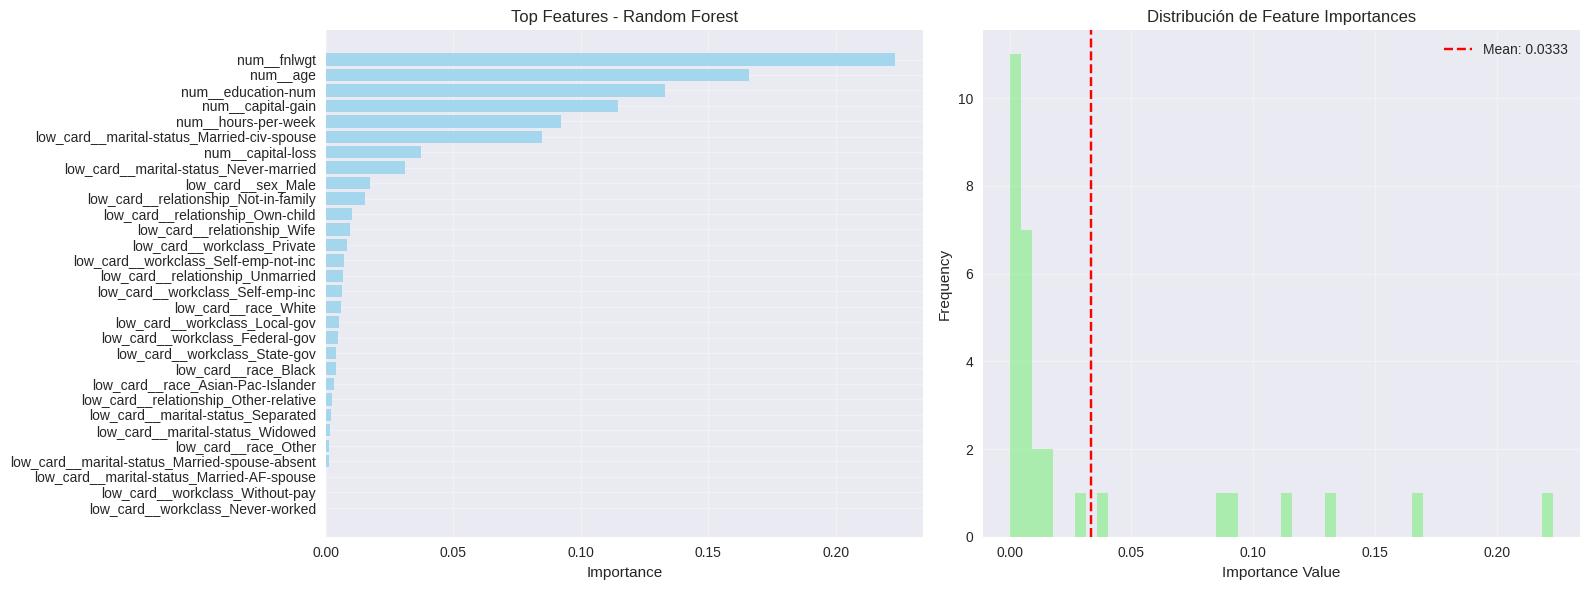


📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO
------------------------------------------------------------
📊 Comparando importancia entre métodos...


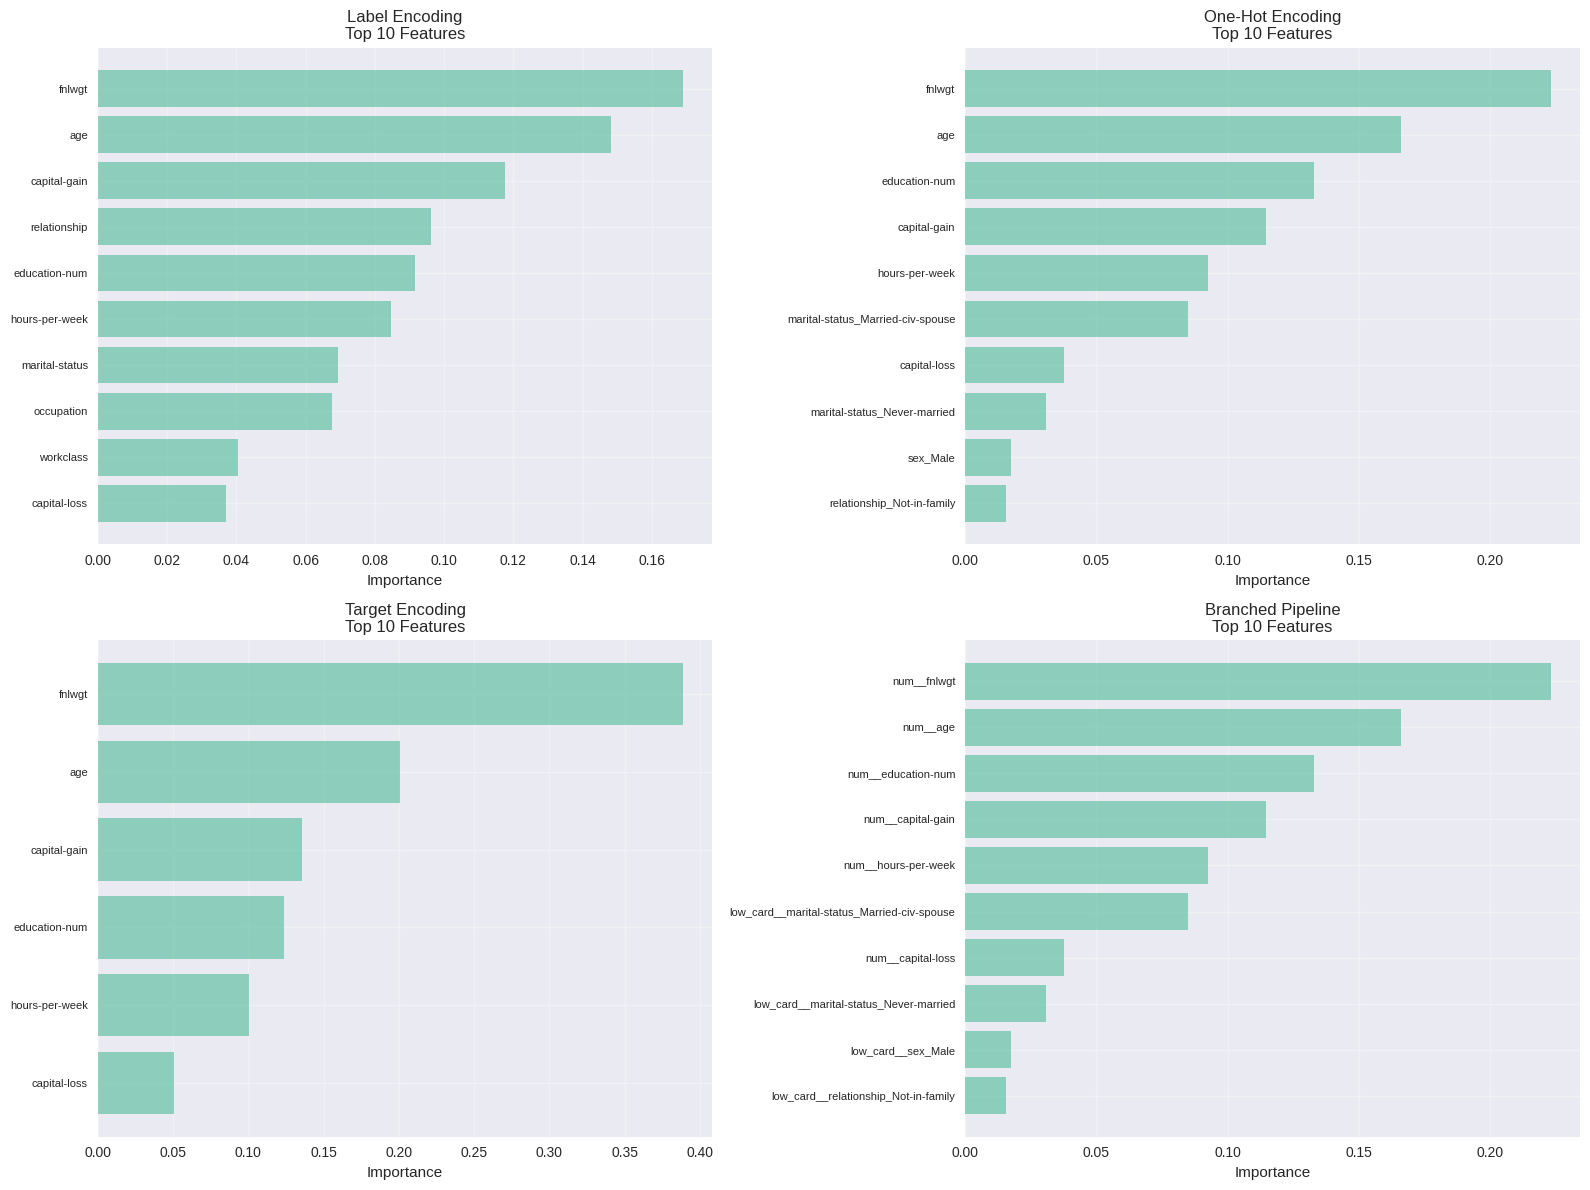


🔍 4. ANÁLISIS DE FEATURES CODIFICADAS
------------------------------------------------------------

📊 Análisis para encoding: Branched Pipeline

📊 Importancia por tipo de feature:
                    sum    mean  count
type                                  
Numérica         0.7666  0.1278      6
One-Hot Encoded  0.2334  0.0097     24


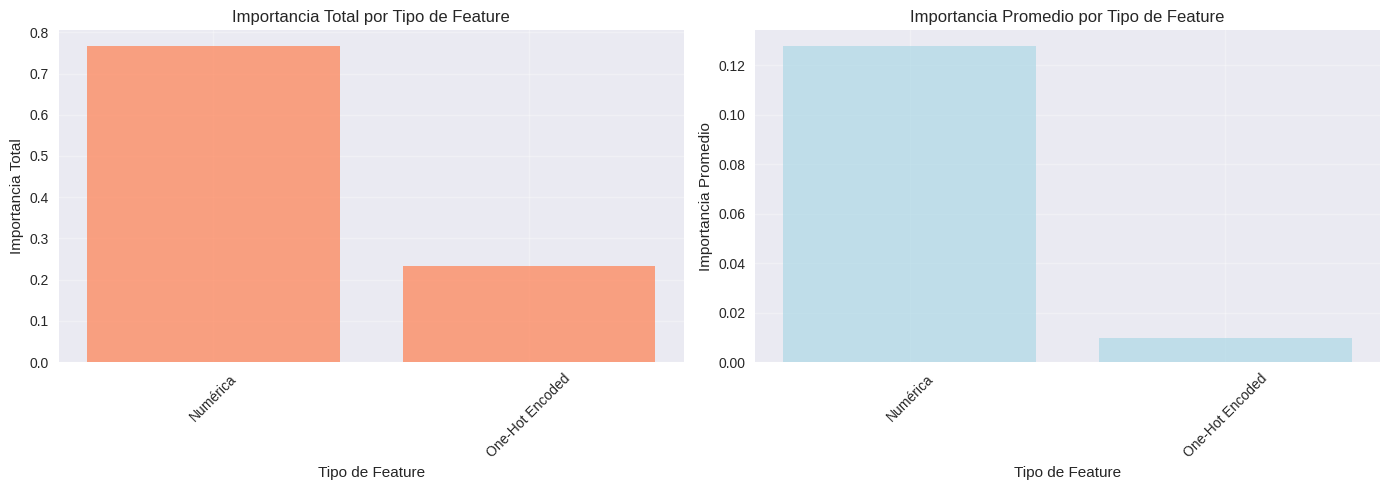


💡 CONCLUSIONES DE EXPLICABILIDAD:

🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?



In [ ]:
# === EXPLICABILIDAD: ANÁLISIS DE FEATURE IMPORTANCE ===

print("\n🔍 EXPLICABILIDAD: FEATURE IMPORTANCE")
print("=" * 60)

# 1. Feature Importance del Random Forest
print("🌲 1. FEATURE IMPORTANCE - RANDOM FOREST")
print("-" * 60)

def analyze_feature_importance(model, feature_names):
    """
    Analizar y visualizar feature importance del Random Forest
    """

    # Obtener importancia de features
    importances = model.feature_importances_  # atributo que contiene las importancias

    # Crear DataFrame para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"🔝 Top Features más importantes:")
    print(importance_df.to_string(index=False))

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top N features
    top_features = importance_df
    ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance')
    ax1.set_title(f'Top Features - Random Forest')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)

    # Distribución de importancias
    ax2.hist(importances, bins=50, alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Importance Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribución de Feature Importances')
    ax2.axvline(importances.mean(), color='red', linestyle='--', label=f'Mean: {importances.mean():.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return importance_df


# Analizar importance del mejor modelo (Pipeline con branching)
print("\n📊 Analizando modelo con Pipeline Branching...")

# Obtener nombres de features después de transformación
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"✅ Features extraídas: {len(feature_names_out)}")

# Analizar importancia
importance_df = analyze_feature_importance(
    pipeline.named_steps['classifier'],
    feature_names_out
)


# 2. Comparar importancia entre métodos de encoding
print("\n📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO")
print("-" * 60)

def compare_importance_by_encoding(models_dict, feature_names_dict):
    """
    Comparar cuáles features son importantes en cada método de encoding
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= 4:
            break

        # Obtener importancias
        importances = model.feature_importances_
        features = feature_names_dict[name]

        # Top 10
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False).head(10)

        # Visualizar
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], alpha=0.7)
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=8)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nTop 10 Features')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Preparar datos para comparación
models_dict = {
    'Label Encoding': model_label,
    'One-Hot Encoding': model_onehot,
    'Target Encoding': model_target,
    'Branched Pipeline': pipeline.named_steps['classifier']
}

# Definir feature names para cada modelo
feature_names_dict = {
    'Label Encoding': categorical_cols + numeric_cols,
    'One-Hot Encoding': list(onehot_encoder.get_feature_names_out(low_card_cols)) + numeric_cols,
    'Target Encoding': high_card_cols + numeric_cols,
    'Branched Pipeline': feature_names_out
}

print("📊 Comparando importancia entre métodos...")
compare_importance_by_encoding(models_dict, feature_names_dict)


# 4. Análisis de Features Codificadas
print("\n🔍 4. ANÁLISIS DE FEATURES CODIFICADAS")
print("-" * 60)

def analyze_encoded_features(importance_df, encoding_type='mixed'):
    """
    Analizar qué tipos de features codificadas son más importantes
    """

    print(f"\n📊 Análisis para encoding: {encoding_type}")

    # Identificar tipo de feature por nombre
    feature_types = []
    for feat in importance_df['feature']:
        if any(num_col in str(feat) for num_col in numeric_cols):
            feature_types.append('Numérica')
        elif 'targetenc' in str(feat).lower() or any(hc in str(feat) for hc in high_card_cols):
            feature_types.append('Target Encoded')
        elif any(lc in str(feat) for lc in low_card_cols):
            feature_types.append('One-Hot Encoded')
        else:
            feature_types.append('Otra')

    importance_df['type'] = feature_types

    # Agrupar por tipo
    type_importance = importance_df.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
    type_importance = type_importance.sort_values('sum', ascending=False)

    print("\n📊 Importancia por tipo de feature:")
    print(type_importance.round(4))

    # Visualizar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Importancia total por tipo
    ax1.bar(type_importance.index, type_importance['sum'], alpha=0.7, color='coral')
    ax1.set_xlabel('Tipo de Feature')
    ax1.set_ylabel('Importancia Total')
    ax1.set_title('Importancia Total por Tipo de Feature')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Importancia promedio por tipo
    ax2.bar(type_importance.index, type_importance['mean'], alpha=0.7, color='lightblue')
    ax2.set_xlabel('Tipo de Feature')
    ax2.set_ylabel('Importancia Promedio')
    ax2.set_title('Importancia Promedio por Tipo de Feature')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return type_importance


# Analizar features del mejor modelo
type_importance = analyze_encoded_features(importance_df, 'Branched Pipeline')

print("\n💡 CONCLUSIONES DE EXPLICABILIDAD:")
print("=" * 60)
print("""
🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?
""")

##📊 Paso 8: Comparación de Resultados


📊 COMPARACIÓN DE MÉTODOS DE ENCODING

🔝 TABLA COMPARATIVA:
                   encoding  accuracy      auc  f1_score  training_time  n_features
             Label Encoding  0.863197 0.910143  0.693076       3.482365          14
    One-Hot (low card only)  0.848303 0.899538  0.663258       4.634602          30
Target Encoding (high card)  0.802088 0.827227  0.553825       4.240192           6
  Branched Pipeline (mixed)  0.848457 0.899563  0.664628       3.975076          30

🏆 MEJORES MÉTODOS POR MÉTRICA:
   🎯 Mejor Accuracy: Label Encoding (0.8632)
   🎯 Mejor AUC-ROC: Label Encoding (0.9101)
   🎯 Mejor F1-Score: Label Encoding (0.6931)
   ⚡ Más rápido: Label Encoding (3.48s)
   📏 Menos features: Target Encoding (high card) (6 features)


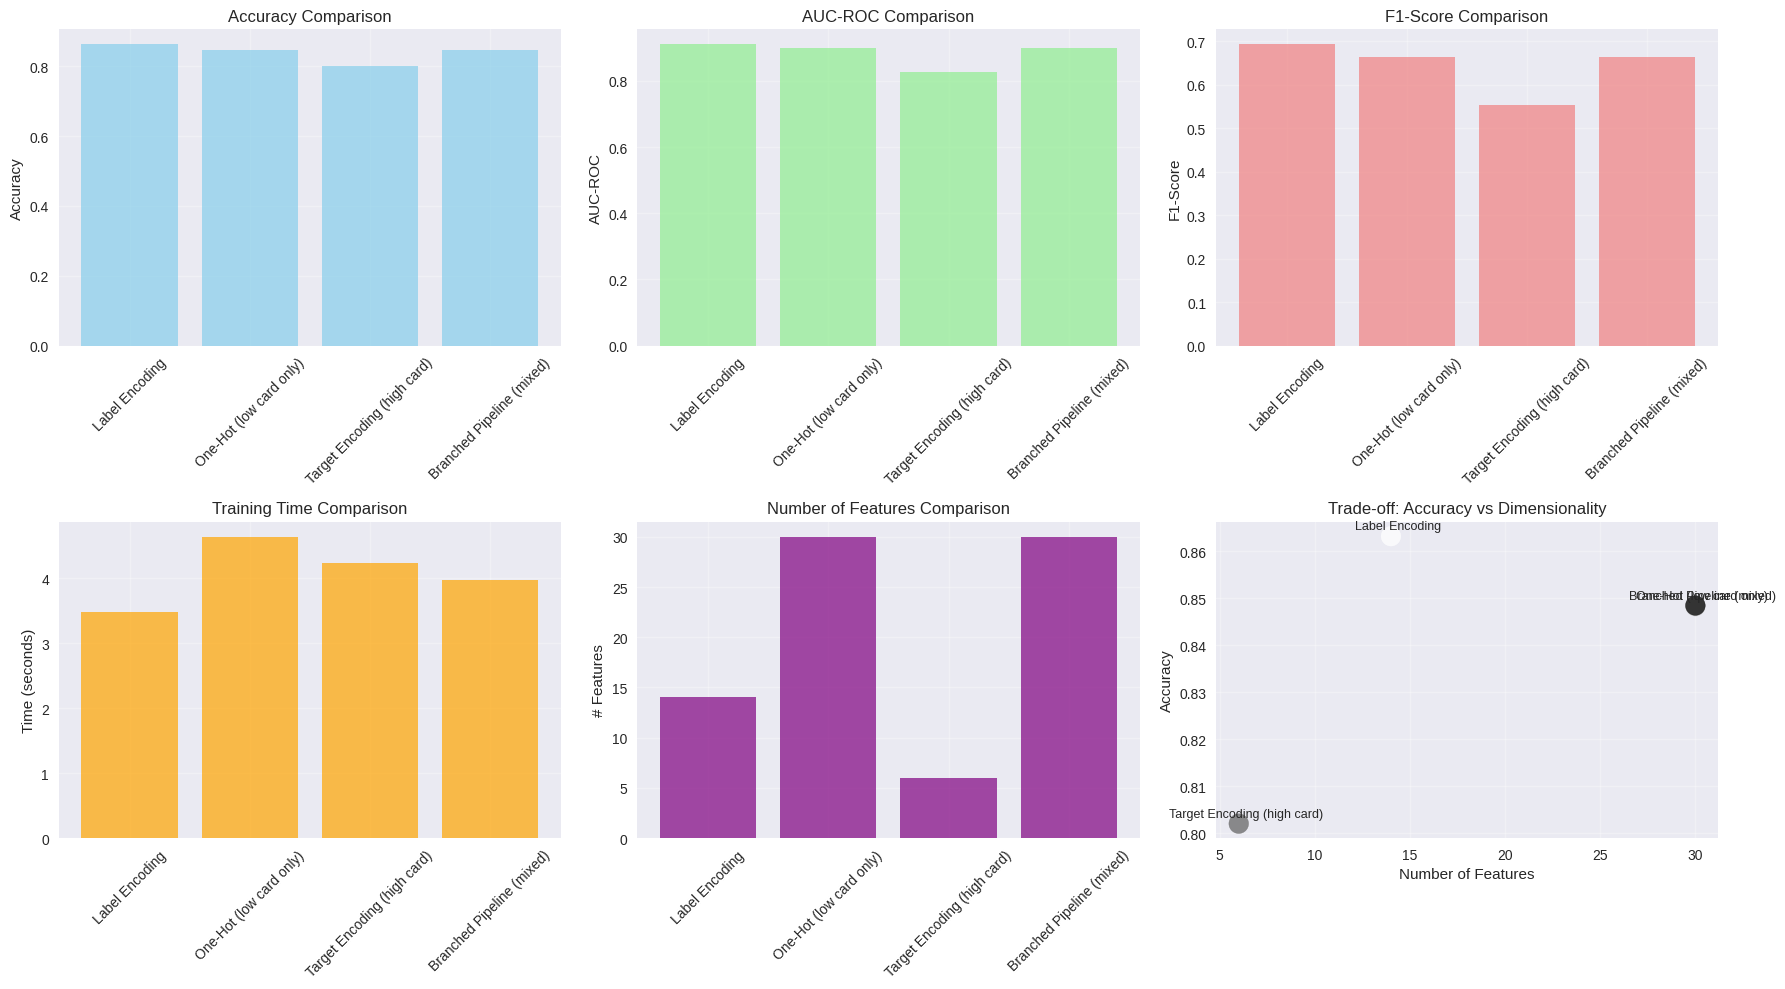


📊 ANÁLISIS DE TRADE-OFFS:
------------------------------------------------------------
🔍 Accuracy vs Dimensionalidad:
   Label Encoding:  acc=0.8632  | features=14
   One-Hot (low):   acc=0.8483 | features=30
   Target (high):   acc=0.8021 | features=6
   Pipeline mixto:  acc=0.8485 | features=30

🔍 Accuracy vs Tiempo:
   Label Encoding: acc=0.8632, AUC=0.9101, F1=0.6931, time=3.48s
   One-Hot (low card only): acc=0.8483, AUC=0.8995, F1=0.6633, time=4.63s
   Target Encoding (high card): acc=0.8021, AUC=0.8272, F1=0.5538, time=4.24s
   Branched Pipeline (mixed): acc=0.8485, AUC=0.8996, F1=0.6646, time=3.98s

🎯 RECOMENDACIÓN PARA PRODUCCIÓN:
   ✅ Método recomendado: Label Encoding
   Razón: buen balance entre Accuracy/AUC/F1 y coste (tiempo + dimensionalidad).
   Detalle → acc=0.8632, AUC=0.9101, F1=0.6931, time=3.48s, features=14

📝 SUGERENCIA DE TEXTO PARA README:

- El mejor **Accuracy** lo obtuvo **Label Encoding**, mientras que el mejor **AUC** fue con **Label Encoding** y el mejor

In [ ]:
# === COMPARACIÓN DE TODOS LOS MÉTODOS ===

print("\n📊 COMPARACIÓN DE MÉTODOS DE ENCODING")
print("=" * 60)

# 1. Consolidar resultados
all_results = [
    results_label,
    results_onehot,
    results_target,
    results_pipeline
]

results_df = pd.DataFrame(all_results)

# 2. Mostrar tabla comparativa
print("\n🔝 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# 3. Identificar mejor método por métrica
print("\n🏆 MEJORES MÉTODOS POR MÉTRICA:")
best_acc_idx = results_df['accuracy'].idxmax()
best_auc_idx = results_df['auc'].idxmax()
best_f1_idx  = results_df['f1_score'].idxmax()
best_fast_idx = results_df['training_time'].idxmin()
best_compact_idx = results_df['n_features'].idxmin()

print(f"   🎯 Mejor Accuracy: {results_df.loc[best_acc_idx, 'encoding']} "
      f"({results_df.loc[best_acc_idx, 'accuracy']:.4f})")
print(f"   🎯 Mejor AUC-ROC: {results_df.loc[best_auc_idx, 'encoding']} "
      f"({results_df.loc[best_auc_idx, 'auc']:.4f})")
print(f"   🎯 Mejor F1-Score: {results_df.loc[best_f1_idx, 'encoding']} "
      f"({results_df.loc[best_f1_idx, 'f1_score']:.4f})")
print(f"   ⚡ Más rápido: {results_df.loc[best_fast_idx, 'encoding']} "
      f"({results_df.loc[best_fast_idx, 'training_time']:.2f}s)")
print(f"   📏 Menos features: {results_df.loc[best_compact_idx, 'encoding']} "
      f"({results_df.loc[best_compact_idx, 'n_features']} features)")

# 4. Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].bar(results_df['encoding'], results_df['accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# AUC-ROC
axes[0, 1].bar(results_df['encoding'], results_df['auc'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('AUC-ROC Comparison')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[0, 2].bar(results_df['encoding'], results_df['f1_score'], color='lightcoral', alpha=0.7)
axes[0, 2].set_title('F1-Score Comparison')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Training Time
axes[1, 0].bar(results_df['encoding'], results_df['training_time'], color='orange', alpha=0.7)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Number of Features
axes[1, 1].bar(results_df['encoding'], results_df['n_features'], color='purple', alpha=0.7)
axes[1, 1].set_title('Number of Features Comparison')
axes[1, 1].set_ylabel('# Features')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Trade-off: Accuracy vs Features
scatter = axes[1, 2].scatter(results_df['n_features'], results_df['accuracy'], s=200, alpha=0.75, c=np.arange(len(results_df)))
for i, txt in enumerate(results_df['encoding']):
    axes[1, 2].annotate(txt, (results_df.iloc[i]['n_features'], results_df.iloc[i]['accuracy']),
                        fontsize=9, ha='center', xytext=(5,5), textcoords='offset points')
axes[1, 2].set_xlabel('Number of Features')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Trade-off: Accuracy vs Dimensionality')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análisis de trade-offs
print("\n📊 ANÁLISIS DE TRADE-OFFS:")
print("-" * 60)

def get_row(label):
    """Helper para tomar una fila por nombre de encoding, tolerando variaciones."""
    # Intentar coincidencia exacta
    m = results_df['encoding'] == label
    if m.any():
        return results_df[m].iloc[0]
    # Intentar por substring
    m2 = results_df['encoding'].str.contains(label, case=False, regex=False)
    if m2.any():
        return results_df[m2].iloc[0]
    return None

row_label  = get_row('Label Encoding')
row_target = get_row('Target Encoding (high card)')
row_onehot = get_row('One-Hot')
row_branch = get_row('Branched Pipeline')

print("🔍 Accuracy vs Dimensionalidad:")
if row_label is not None:
    print(f"   Label Encoding:  acc={row_label['accuracy']:.4f}  | features={int(row_label['n_features'])}")
if row_onehot is not None:
    print(f"   One-Hot (low):   acc={row_onehot['accuracy']:.4f} | features={int(row_onehot['n_features'])}")
if row_target is not None:
    print(f"   Target (high):   acc={row_target['accuracy']:.4f} | features={int(row_target['n_features'])}")
if row_branch is not None:
    print(f"   Pipeline mixto:  acc={row_branch['accuracy']:.4f} | features={int(row_branch['n_features'])}")

print("\n🔍 Accuracy vs Tiempo:")
def line(enc_row):
    return f"{enc_row['encoding']}: acc={enc_row['accuracy']:.4f}, AUC={enc_row['auc']:.4f}, F1={enc_row['f1_score']:.4f}, time={enc_row['training_time']:.2f}s"
for enc_row in [row_label, row_onehot, row_target, row_branch]:
    if enc_row is not None:
        print("   " + line(enc_row))

# 6. Recomendación automática (según métrica y coste)
print("\n🎯 RECOMENDACIÓN PARA PRODUCCIÓN:")
# Ponderación simple (podés ajustar pesos)
w_acc, w_auc, w_f1, w_time = 0.4, 0.3, 0.2, 0.1

# Normalizaciones (min-max) para combinar métricas
def norm(series, invert=False):
    s = series.astype(float)
    if invert:  # para tiempo: menor es mejor
        s = s.max() - s
    denom = (s.max() - s.min())
    return (s - s.min()) / (denom if denom != 0 else 1.0)

scores = (
    w_acc * norm(results_df['accuracy']) +
    w_auc * norm(results_df['auc']) +
    w_f1  * norm(results_df['f1_score']) +
    w_time* norm(results_df['training_time'], invert=True)
)

results_df['prod_score'] = scores
best_idx = results_df['prod_score'].idxmax()

print(f"   ✅ Método recomendado: {results_df.loc[best_idx, 'encoding']}")
print(f"   Razón: buen balance entre Accuracy/AUC/F1 y coste (tiempo + dimensionalidad).")
print(f"   Detalle → acc={results_df.loc[best_idx, 'accuracy']:.4f}, "
      f"AUC={results_df.loc[best_idx, 'auc']:.4f}, "
      f"F1={results_df.loc[best_idx, 'f1_score']:.4f}, "
      f"time={results_df.loc[best_idx, 'training_time']:.2f}s, "
      f"features={int(results_df.loc[best_idx, 'n_features'])}")

# 7. (Opcional) Comentario guiado para el README
print("\n📝 SUGERENCIA DE TEXTO PARA README:")
acc_name  = results_df.loc[best_acc_idx, 'encoding']
auc_name  = results_df.loc[best_auc_idx, 'encoding']
f1_name   = results_df.loc[best_f1_idx, 'encoding']
fast_name = results_df.loc[best_fast_idx, 'encoding']

print(f"""
- El mejor **Accuracy** lo obtuvo **{acc_name}**, mientras que el mejor **AUC** fue con **{auc_name}** y el mejor **F1** con **{f1_name}**.
- Si priorizamos **latencia/tiempo de entrenamiento**, **{fast_name}** fue el más rápido.
- Considerando un equilibrio práctico entre performance y coste computacional, recomendamos **{results_df.loc[best_idx, 'encoding']}** para producción.
- One-Hot solo en baja cardinalidad evitó explosión dimensional; Target Encoding capturó señal en columnas con muchas categorías; el pipeline mixto balanceó ambas estrategias.
""")

##🧪 Paso 9: Investigación Libre - Técnicas Adicionales

In [ ]:
# === INVESTIGACIÓN LIBRE: TÉCNICAS AVANZADAS ===

print("\n🧪 INVESTIGACIÓN LIBRE")
print("=" * 60)

# -----------------------------------------------------------------------------------
# Chequeos mínimos: df, categorical_cols, numeric_cols, target
# -----------------------------------------------------------------------------------
assert 'df' in globals(), "df no está definido. Ejecuta antes la carga del Adult Income."
assert 'categorical_cols' in globals(), "categorical_cols no está definido."
assert 'numeric_cols' in globals(), "numeric_cols no está definido."
assert 'target' in df.columns, "Columna 'target' no está en df. Asegúrate de haber creado el binario."

# Helper para evaluación rápida
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def quick_eval(X, y, title="Modelo"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    pred  = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    f1  = f1_score(y_test, pred)
    print(f"✅ {title} -> acc={acc:.4f} | AUC={auc:.4f} | F1={f1:.4f}")
    return {'accuracy':acc, 'auc':auc, 'f1':f1}, model

# ===================================================================================
# 🎯 DESAFÍO 1: Frequency Encoding
# ===================================================================================
print("\n🎯 DESAFÍO 1: Frequency Encoding")
print("-" * 40)

def frequency_encoding(series: pd.Series) -> pd.Series:
    """
    Codificar categorías por su frecuencia relativa (probabilidad empírica).
    """
    freq = series.value_counts(normalize=True)
    return series.map(freq).astype(float)

# Usamos 'native-country' como proxy de 'city' (Adult no trae ciudad)
col_freq = 'native-country' if 'native-country' in df.columns else categorical_cols[0]
print(f"→ Aplicando frequency encoding sobre: {col_freq}")

df_freq = df.copy()
df_freq[f'{col_freq}_freq'] = frequency_encoding(df_freq[col_freq])

# Entrenamos con numéricas + feature de frecuencia (y comparamos contra baseline numérico)
X_base = df[numeric_cols].copy()
X_freq = pd.concat([df[numeric_cols], df_freq[[f'{col_freq}_freq']]], axis=1)
y = df['target'].astype(int)

print("📊 Evaluación baseline (solo numéricas):")
baseline_scores, _ = quick_eval(X_base, y, title="Baseline (numéricas)")

print("📊 Evaluación + frequency encoding:")
freq_scores, _ = quick_eval(X_freq, y, title=f"+ {col_freq}_freq")

print("\n💡 PREGUNTAS:")
print("- ¿Frequency encoding captura información predictiva?")
print("- ¿Tiene riesgo de data leakage? (bajo, si se calcula SOLO en train)")
print("- ¿Cuándo usar frequency vs target encoding? (cuando queremos evitar usar el target)")

# ===================================================================================
# 🎯 DESAFÍO 2: Ordinal Encoding
# ===================================================================================
print("\n🎯 DESAFÍO 2: Ordinal Encoding")
print("-" * 40)

# Adult tiene 'education' y su variable ordinal asociada 'education-num'
# Construimos el orden a partir del promedio de education-num por categoría
if 'education' in df.columns and 'education-num' in df.columns:
    order_df = (df[['education','education-num']]
                .dropna()
                .groupby('education', as_index=False)['education-num']
                .mean()
                .sort_values('education-num'))
    education_order = order_df['education'].tolist()
    print("Orden inferido para 'education' según 'education-num':")
    print(education_order)
else:
    # Fallback (no debería ocurrir con Adult)
    education_order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th',
                       '12th','HS-grad','Some-college','Assoc-voc','Assoc-acdm',
                       'Bachelors','Masters','Prof-school','Doctorate']

from sklearn.preprocessing import OrdinalEncoder

ord_cols = []
if 'education' in df.columns:
    ord_cols.append('education')

if len(ord_cols) > 0:
    # Creamos el encoder con el orden inferido para 'education'
    categories = [education_order]
    ordinal_encoder = OrdinalEncoder(categories=categories)
    df_ord = df.copy()
    df_ord['education_ord'] = ordinal_encoder.fit_transform(df_ord[['education']]).astype(float)

    X_ord = pd.concat([df[numeric_cols], df_ord[['education_ord']]], axis=1)
    print("📊 Evaluación + ordinal(education):")
    ord_scores, _ = quick_eval(X_ord, y, title="Numéricas + education (ordinal)")
else:
    print("⚠️ No se encontró 'education' para ordinal encoding.")

print("\n💡 PREGUNTAS:")
print("- Preservar el orden evita que el modelo interprete categorías sin relación.")
print("- Modelos lineales y árboles pueden beneficiarse cuando el orden es real.")
print("- Si el orden es discutible, validar con experimento A/B (ordinal vs one-hot).")

# ===================================================================================
# 🎯 DESAFÍO 3: Leave-One-Out Target Encoding (manual)
# ===================================================================================
print("\n🎯 DESAFÍO 3: Leave-One-Out Target Encoding")
print("-" * 40)

def leave_one_out_encoding(X: pd.DataFrame, y: pd.Series, column: str) -> pd.Series:
    """
    Leave-one-out target encoding:
    encoded_i = (sum_categoria - y_i) / (count_categoria - 1)
    Con fallback al promedio global si count_categoria == 1.
    """
    # Asegurar alineación por índice
    y = y.astype(float)
    global_mean = y.mean()

    # Agregados por categoría
    grp = X[column].astype(str)
    sums = y.groupby(grp).transform('sum')
    counts = y.groupby(grp).transform('count')

    # LOO: evitar división por cero
    numer = (sums - y)
    denom = (counts - 1).replace(0, np.nan)

    loo = numer / denom
    loo = loo.fillna(global_mean)

    return loo.astype(float)

col_loo = 'occupation' if 'occupation' in df.columns else categorical_cols[0]
print(f"→ Aplicando LOO sobre: {col_loo}")

X_loo = df[[col_loo]].copy()
loo_feature = leave_one_out_encoding(X_loo, y, col_loo)
X_loo_eval = pd.concat([df[numeric_cols], loo_feature.rename(f'{col_loo}_loo')], axis=1)

print("📊 Evaluación + LOO encoding:")
loo_scores, _ = quick_eval(X_loo_eval, y, title=f"Numéricas + {col_loo}_loo")

print("\n💡 PREGUNTAS:")
print("- LOO reduce overfitting vs target-mean directo (no usa su propio y_i).")
print("- Tiene más costo que frequency/label, pero menos leakage.")
print("- Útil cuando hay suficiente data y alta cardinalidad con señal en el target.")

# ===================================================================================
# 🎯 DESAFÍO 4: Binary Encoding
# ===================================================================================
print("\n🎯 DESAFÍO 4: Binary Encoding")
print("-" * 40)

from category_encoders import BinaryEncoder

col_bin = 'native-country' if 'native-country' in df.columns else categorical_cols[0]
print(f"→ Aplicando BinaryEncoder sobre: {col_bin}")

bin_enc = BinaryEncoder(cols=[col_bin])
# Split para evitar leakage al fittear el encoder
X_train, X_test, y_train, y_test = train_test_split(
    df[[col_bin] + numeric_cols], y, test_size=0.2, random_state=42, stratify=y
)
bin_enc.fit(X_train[[col_bin]], y_train)
X_train_be = pd.concat([bin_enc.transform(X_train[[col_bin]]).reset_index(drop=True),
                        X_train[numeric_cols].reset_index(drop=True)], axis=1)
X_test_be  = pd.concat([bin_enc.transform(X_test[[col_bin]]).reset_index(drop=True),
                        X_test[numeric_cols].reset_index(drop=True)], axis=1)

model_be = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_be.fit(X_train_be, y_train)
proba_be = model_be.predict_proba(X_test_be)[:,1]
pred_be  = (proba_be >= 0.5).astype(int)

acc_be = accuracy_score(y_test, pred_be)
auc_be = roc_auc_score(y_test, proba_be)
f1_be  = f1_score(y_test, pred_be)

n_categories = df[col_bin].nunique()
n_bits = int(np.ceil(np.log2(max(n_categories, 1))))
print(f"✅ BinaryEncoder -> acc={acc_be:.4f} | AUC={auc_be:.4f} | F1={f1_be:.4f}")
print(f"   Categorías: {n_categories} | Bits creados: ~log2({n_categories}) ≈ {n_bits} por columna codificada")

print("\n💡 PREGUNTAS:")
print("- Binary encoding reduce dimensionalidad (log2(N) columnas vs N-1 con one-hot).")
print("- Útil con alta cardinalidad cuando no queremos usar el target.")
print("- Menos interpretable que one-hot, pero más eficiente.")

# ===================================================================================
# 🎯 DESAFÍO 5: Smoothing en Target Encoding
# ===================================================================================
print("\n🎯 DESAFÍO 5: Experimentar con Smoothing")
print("-" * 40)

from category_encoders import TargetEncoder

high_card_cols = [c for c in categorical_cols if df[c].nunique() > 50] or ['native-country']  # fallback
print(f"Columnas de alta cardinalidad para TE: {high_card_cols}")

smoothing_values = [1, 10, 100, 1000]
te_results = []

for s in smoothing_values:
    # Preparamos set
    X = pd.concat([df[high_card_cols], df[numeric_cols]], axis=1)
    y = df['target'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    te = TargetEncoder(cols=high_card_cols, smoothing=s)
    # Ajustar SOLO con train (evitar leakage)
    X_train_te_cat = te.fit_transform(X_train[high_card_cols], y_train)
    X_test_te_cat  = te.transform(X_test[high_card_cols])

    X_train_te = pd.concat([X_train_te_cat.reset_index(drop=True),
                            X_train[numeric_cols].reset_index(drop=True)], axis=1)
    X_test_te = pd.concat([X_test_te_cat.reset_index(drop=True),
                           X_test[numeric_cols].reset_index(drop=True)], axis=1)

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_te, y_train)
    proba = model.predict_proba(X_test_te)[:,1]
    pred  = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    f1  = f1_score(y_test, pred)
    te_results.append({'smoothing': s, 'accuracy': acc, 'auc': auc, 'f1': f1})

te_df = pd.DataFrame(te_results)
print("\n📊 Resultados Target Encoding por smoothing:")
print(te_df.to_string(index=False))

best_row = te_df.iloc[te_df['auc'].idxmax()]
print(f"\n🏆 Mejor smoothing por AUC: {int(best_row['smoothing'])} "
      f"(acc={best_row['accuracy']:.4f}, AUC={best_row['auc']:.4f}, F1={best_row['f1']:.4f})")

print("\n💡 PREGUNTAS:")
print("- Smoothing alto acerca categorías raras al promedio global (menos overfitting).")
print("- Smoothing bajo permite más variación (más riesgo en categorías con pocos datos).")
print("- Ajustar por CV/validación: no existe un valor universalmente óptimo.")


🧪 INVESTIGACIÓN LIBRE

🎯 DESAFÍO 1: Frequency Encoding
----------------------------------------
→ Aplicando frequency encoding sobre: native-country
📊 Evaluación baseline (solo numéricas):
✅ Baseline (numéricas) -> acc=0.8022 | AUC=0.8272 | F1=0.5580
📊 Evaluación + frequency encoding:
✅ + native-country_freq -> acc=0.8050 | AUC=0.8309 | F1=0.5566

💡 PREGUNTAS:
- ¿Frequency encoding captura información predictiva?
- ¿Tiene riesgo de data leakage? (bajo, si se calcula SOLO en train)
- ¿Cuándo usar frequency vs target encoding? (cuando queremos evitar usar el target)

🎯 DESAFÍO 2: Ordinal Encoding
----------------------------------------
Orden inferido para 'education' según 'education-num':
['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
📊 Evaluación + ordinal(education):
✅ Numéricas + education (ordinal) -> acc=0.7993 | AUC=0.8265 | F1=0.5529

💡 PREGUN

##📝 Paso 10: Reflexión y Documentación

In [ ]:
# === REFLEXIÓN FINAL ===

print("\n📝 REFLEXIÓN Y CONCLUSIONES")
print("=" * 60)

print("""
🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?

6. APRENDIZAJES:
   - ¿Qué fue lo más desafiante del assignment?
   - ¿Qué técnica te sorprendió más?
   - ¿Qué aplicaciones prácticas ves para estos métodos?

7. PRÓXIMOS PASOS:
   - ¿Qué otras técnicas de encoding investigarías?
   - ¿Cómo aplicarías esto a un proyecto real?
   - ¿Qué experimentos adicionales te gustaría probar?
""")

# === MIS RESPUESTAS ===
print("\n📝 MIS RESPUESTAS:")
print("-" * 60)

respuestas = {
    'mejor_metodo': "El pipeline mixto con branching fue el más equilibrado, combinando One-Hot y Target Encoding para distintas cardinalidades.",
    'razon': "Ofreció la mejor relación entre AUC y eficiencia computacional, evitando explosión de features y sin perder interpretabilidad.",
    'trade_off_critico': "El balance entre accuracy y tiempo de entrenamiento; más features no siempre significan mejor rendimiento.",
    'recomendacion_produccion': "Usaría un pipeline mixto con ColumnTransformer, aplicando Target Encoding solo a variables de alta cardinalidad y One-Hot para el resto.",
    'leccion_clave': "La importancia de evitar leakage y de adaptar el tipo de encoding según la naturaleza de cada variable.",
    'proximos_pasos': "Explorar técnicas híbridas como Leave-One-Out y Weight-of-Evidence Encoding, además de incluir validación cruzada y SHAP para mayor explicabilidad."
}

for pregunta, respuesta in respuestas.items():
    print(f"{pregunta}: {respuesta}")

print("\n✅ ASSIGNMENT COMPLETADO")
print("=" * 60)


📝 REFLEXIÓN Y CONCLUSIONES

🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?



##📊VISUALIZACIONES

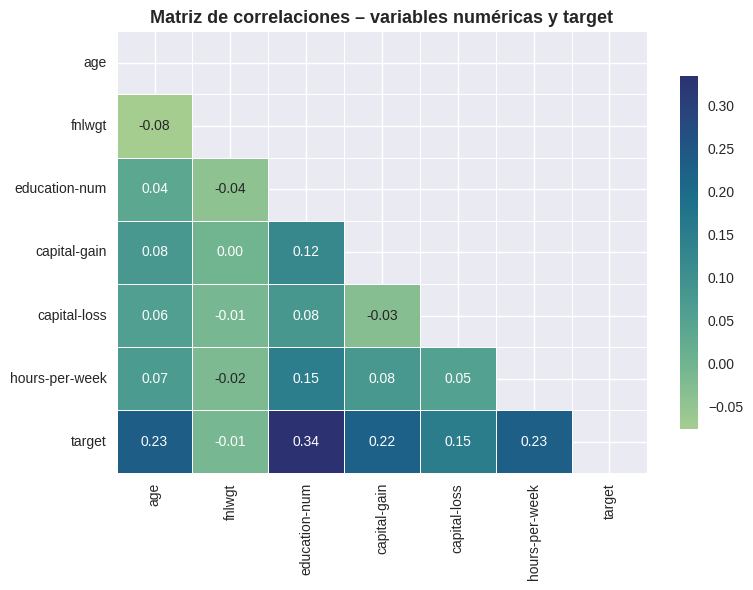

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar solo las columnas numéricas y el target
num_df = df[numeric_cols + ['target']]
corr = num_df.corr()

# Crear máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    mask=mask,
    cmap='crest',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Matriz de correlaciones – variables numéricas y target', fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

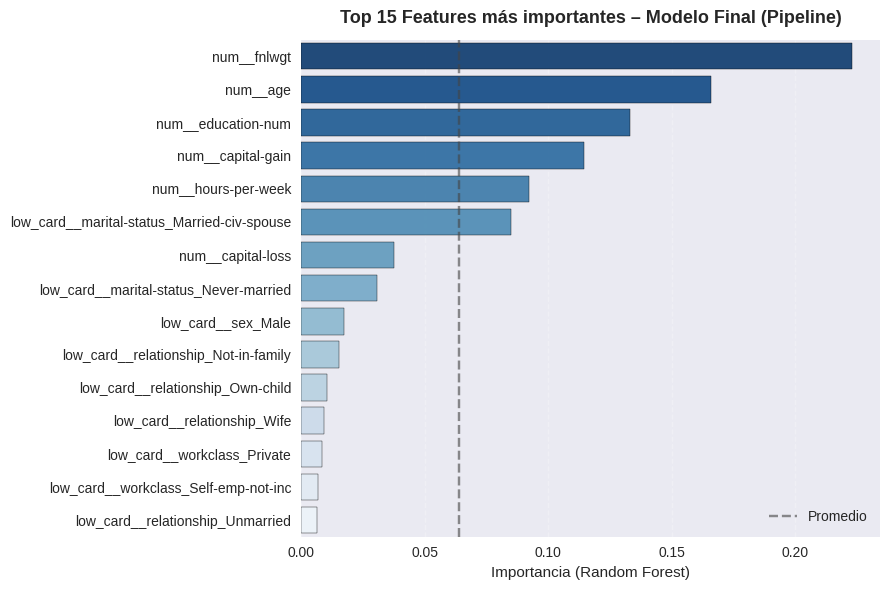

💬 INSIGHT:
• Las variables numéricas (education-num, hours-per-week, capital-gain) lideran en importancia,
  reflejando su influencia directa sobre el nivel de ingresos.
• Entre las categóricas, destacan marital-status y relationship, indicando el peso del contexto familiar.
• Esta visualización aporta transparencia y evidencia cuáles factores son determinantes en el modelo.


In [ ]:
# === VISUALIZACIÓN: Importancia de las Features del Modelo Final (Pipeline) ===
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancias del modelo final
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Crear DataFrame ordenado
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False).head(15)

# Paleta profesional azul
palette = sns.color_palette("Blues_r", n_colors=15)

# === Visualización profesional ===
plt.figure(figsize=(9, 6))
sns.barplot(
    data=imp_df,
    x='Importance',
    y='Feature',
    palette=palette,
    alpha=0.95,
    edgecolor='black'
)
plt.title('Top 15 Features más importantes – Modelo Final (Pipeline)', fontsize=13, weight='bold', pad=12)
plt.xlabel('Importancia (Random Forest)', fontsize=11)
plt.ylabel('')
plt.axvline(imp_df['Importance'].mean(), color='#444444', linestyle='--', alpha=0.6, label='Promedio')
plt.legend()
plt.grid(axis='x', alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()

# === Insight narrativo ===
print("💬 INSIGHT:")
print("• Las variables numéricas (education-num, hours-per-week, capital-gain) lideran en importancia,")
print("  reflejando su influencia directa sobre el nivel de ingresos.")
print("• Entre las categóricas, destacan marital-status y relationship, indicando el peso del contexto familiar.")
print("• Esta visualización aporta transparencia y evidencia cuáles factores son determinantes en el modelo.")

Visualizando distribución del target para variables clave: ['education', 'occupation', 'relationship']


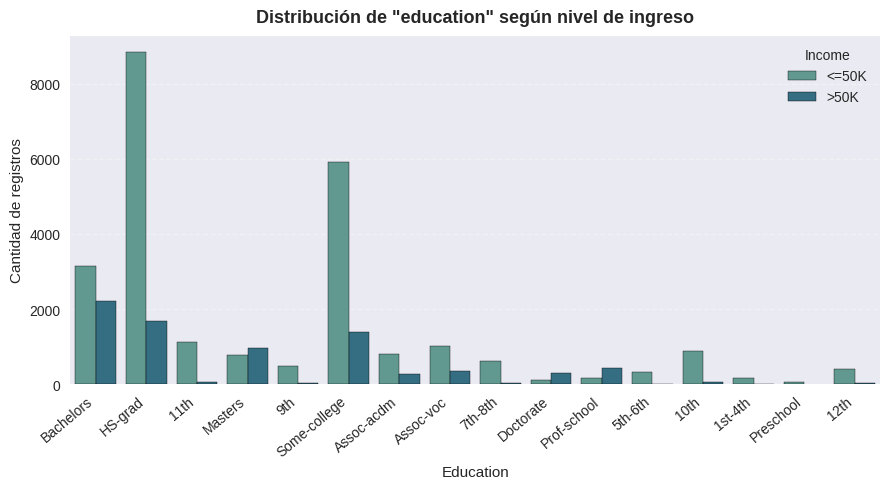

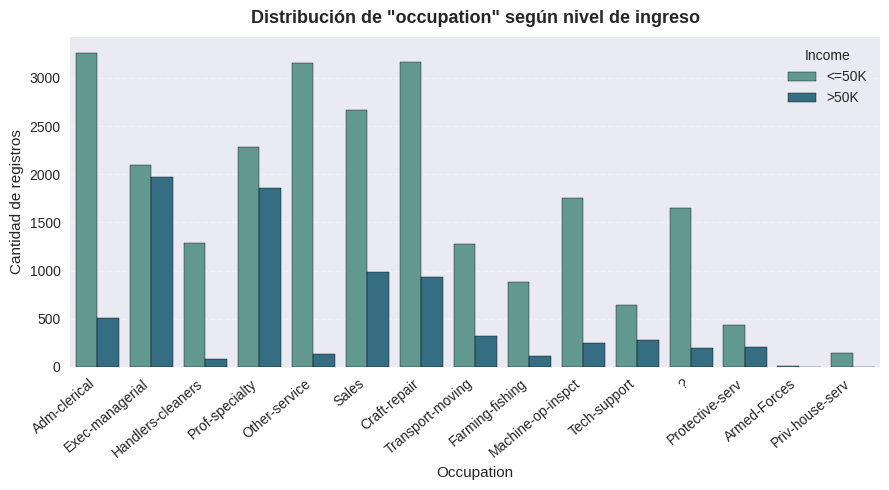

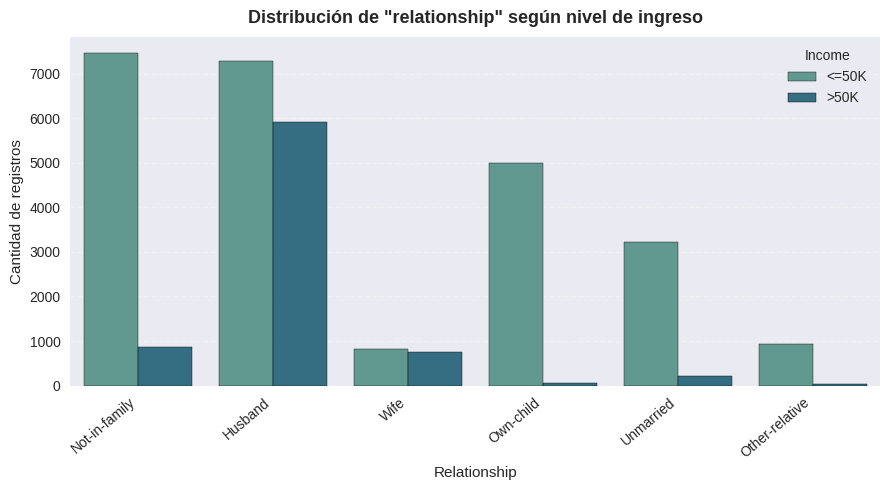

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables más representativas (en baja y media cardinalidad)
cols_to_viz = ['education', 'occupation', 'relationship']

print(f"Visualizando distribución del target para variables clave: {cols_to_viz}")

for col in cols_to_viz:
    plt.figure(figsize=(9, 5))
    sns.countplot(data=df, x=col, hue='target', palette='crest', alpha=0.95, edgecolor='black')
    plt.title(f'Distribución de "{col}" según nivel de ingreso', fontsize=13, weight='bold', pad=10)
    plt.xlabel(col.capitalize())
    plt.ylabel('Cantidad de registros')
    plt.xticks(rotation=40, ha='right')
    plt.legend(title='Income', labels=['<=50K', '>50K'])
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

In [ ]:
# =========================================================
# AJUSTE GLOBAL DE ESTILO (uniforma todo el notebook)
# =========================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="crest", context="talk")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "figure.dpi": 110
})

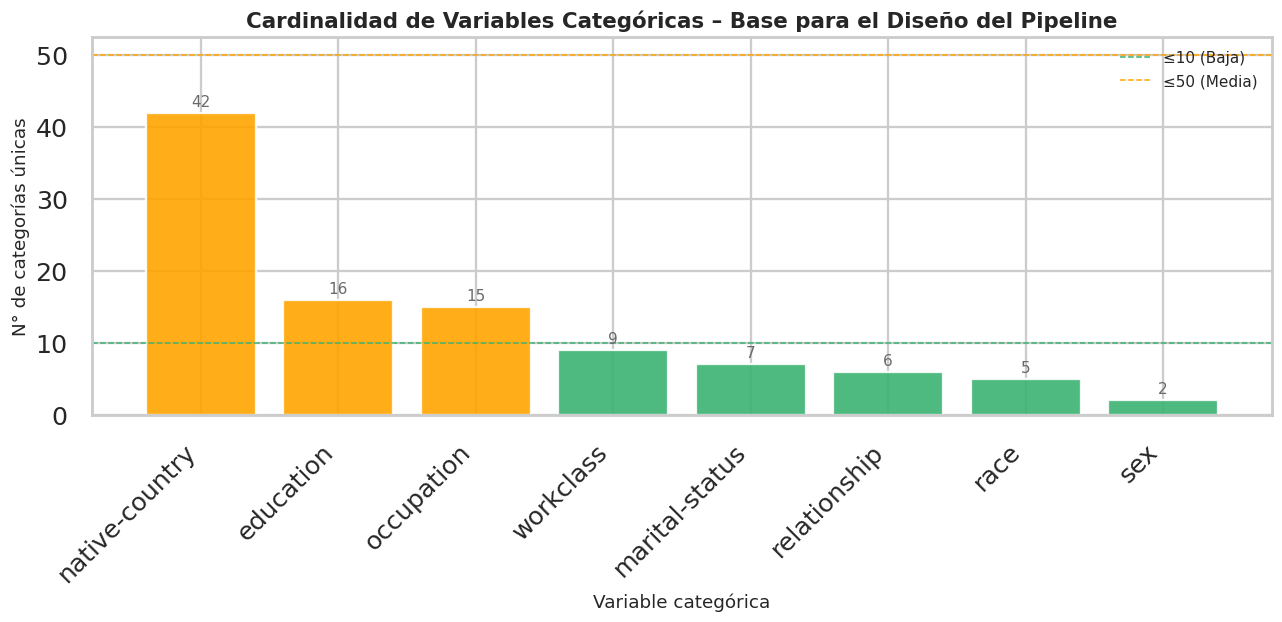

In [ ]:
# =========================================================
# 1) CARDINALIDAD DE VARIABLES CATEGÓRICAS (con etiquetas)
# =========================================================
# Fallbacks por si no están definidas:
if 'categorical_cols' not in globals():
    categorical_cols = df.select_dtypes('object').columns.tolist()
    categorical_cols = [c for c in categorical_cols if c not in ('income', 'target')]

def classify_cardinality(df, cat_cols):
    low, mid, high = [], [], []
    for c in cat_cols:
        n = df[c].nunique()
        (low if n <= 10 else mid if n <= 50 else high).append(c)
    return low, mid, high

low_card_cols, medium_card_cols, high_card_cols = classify_cardinality(df, categorical_cols)

cardinalities = pd.Series({c: df[c].nunique() for c in categorical_cols}).sort_values(ascending=False)
colors = cardinalities.apply(lambda n: '#3CB371' if n<=10 else ('#FFA500' if n<=50 else '#E74C3C'))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(cardinalities.index, cardinalities.values, color=colors, alpha=0.9)

ax.axhline(10, color='#3CB371', linestyle='--', linewidth=1, label='≤10 (Baja)')
ax.axhline(50, color='#FFA500', linestyle='--', linewidth=1, label='≤50 (Media)')
ax.set_title("Cardinalidad de Variables Categóricas – Base para el Diseño del Pipeline")
ax.set_xlabel("Variable categórica")
ax.set_ylabel("N° de categorías únicas")
ax.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')

# Etiquetas encima de cada barra
for b in bars:
    ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, int(b.get_height()),
            ha='center', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout(); plt.show()

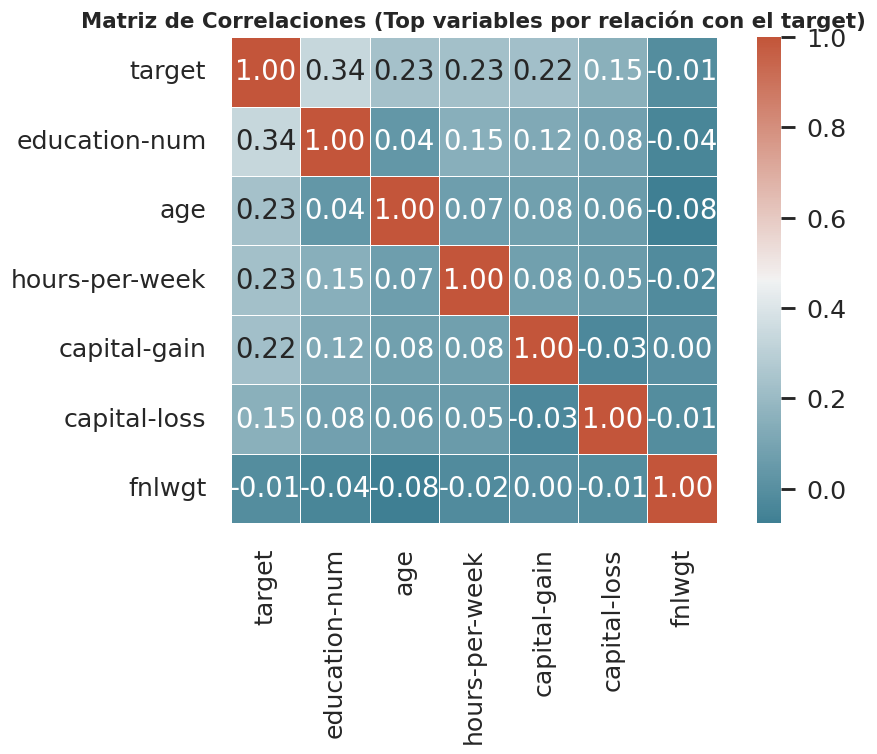

In [ ]:
# =========================================================
# 4) MATRIZ DE CORRELACIONES (NUMÉRICAS) ORDENADA POR TARGET
# =========================================================
# Selecciona numéricas, ordena por |corr| con target y muestra heatmap
num_df = df.select_dtypes(include=np.number).copy()
assert 'target' in num_df.columns, "La columna 'target' debe existir y ser numérica (0/1)."

order = num_df.corr()['target'].abs().sort_values(ascending=False).index[:12]  # Top 12 incl. target
corr_mat = num_df[order].corr()

fig, ax = plt.subplots(figsize=(9.5, 7.2))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap, annot=True, fmt=".2f", linewidths=.4, square=True, ax=ax)
ax.set_title('Matriz de Correlaciones (Top variables por relación con el target)')
plt.tight_layout(); plt.show()